<a href="https://colab.research.google.com/github/Soumyadeep-Basak/Fault-prediction-in-software-systems/blob/main/SWFault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu,sigmoid
%load_ext tensorboard
!pip install requests beautifulsoup4
!git clone https://github.com/klainfo/NASADefectDataset.git

Cloning into 'NASADefectDataset'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 101 (delta 62), reused 101 (delta 62), pack-reused 0
Receiving objects: 100% (101/101), 1.94 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
from scipy.io import arff
data, meta = arff.loadarff("/content/NASADefectDataset/CleanedData/MDP/D''/JM1.arff")
df = pd.DataFrame(data)


print(df.head())


   LOC_BLANK  BRANCH_COUNT  LOC_CODE_AND_COMMENT  LOC_COMMENTS  \
0        3.0           1.0                   0.0           0.0   
1        3.0           3.0                   0.0           0.0   
2        1.0           5.0                   0.0           0.0   
3        5.0           9.0                   0.0           4.0   
4        4.0           1.0                   0.0           0.0   

   CYCLOMATIC_COMPLEXITY  DESIGN_COMPLEXITY  ESSENTIAL_COMPLEXITY  \
0                    1.0                1.0                   1.0   
1                    2.0                1.0                   1.0   
2                    3.0                1.0                   1.0   
3                    5.0                5.0                   1.0   
4                    1.0                1.0                   1.0   

   LOC_EXECUTABLE  HALSTEAD_CONTENT  HALSTEAD_DIFFICULTY  ...  \
0            12.0             57.51                 4.26  ...   
1             9.0             20.01                12.60  

In [ ]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=f22e87a7a4bf69e50d2d9a631625754aa571904e58779b776017abf421212c6c
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
from ydata_profiling import ProfileReport

In [3]:
def transform_label_column(df,column_name):
    df[column_name]=df[column_name].map(lambda x : 0 if x.decode("utf-8")=="N" else 1)

    df["label"].value_counts()
    return df


In [4]:

df=transform_label_column(df,"label")


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7720 entries, 0 to 7719
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LOC_BLANK              7720 non-null   float64
 1   BRANCH_COUNT           7720 non-null   float64
 2   LOC_CODE_AND_COMMENT   7720 non-null   float64
 3   LOC_COMMENTS           7720 non-null   float64
 4   CYCLOMATIC_COMPLEXITY  7720 non-null   float64
 5   DESIGN_COMPLEXITY      7720 non-null   float64
 6   ESSENTIAL_COMPLEXITY   7720 non-null   float64
 7   LOC_EXECUTABLE         7720 non-null   float64
 8   HALSTEAD_CONTENT       7720 non-null   float64
 9   HALSTEAD_DIFFICULTY    7720 non-null   float64
 10  HALSTEAD_EFFORT        7720 non-null   float64
 11  HALSTEAD_ERROR_EST     7720 non-null   float64
 12  HALSTEAD_LENGTH        7720 non-null   float64
 13  HALSTEAD_LEVEL         7720 non-null   float64
 14  HALSTEAD_PROG_TIME     7720 non-null   float64
 15  HALS

In [ ]:
profile = ProfileReport(df.head(1000))
profile.to_file('report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:

from  sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df.dropna()
df=df.drop_duplicates()
y=df["label"]
x=df.drop("label",axis=1)
scaler = MinMaxScaler()
x[x.columns] = scaler.fit_transform(x[x.columns])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.5,random_state=42)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr,model_checkpoint])

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100
41/43 [===========================>..] - ETA: 0s - loss: 0.5739 - accuracy: 0.7790
Epoch 1: val_loss improved from inf to 0.53160, saving model to best_model.h5
43/43 [==============================] - 6s 58ms/step - loss: 0.5706 - accuracy: 0.7809 - val_loss: 0.5316 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 2/100
 3/43 [=>............................] - ETA: 1s - loss: 0.4197 - accuracy: 0.8594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7946
Epoch 2: val_loss improved from 0.53160 to 0.53051, saving model to best_model.h5
43/43 [==============================] - 2s 46ms/step - loss: 0.5162 - accuracy: 0.7946 - val_loss: 0.5305 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 3/100
41/43 [===========================>..] - ETA: 0s - loss: 0.5217 - accuracy: 0.7931
Epoch 3: val_loss did not improve from 0.53051
43/43 [==============================] - 2s 43ms/step - loss: 0.5198 - accuracy: 0.7942 - val_loss: 0.5328 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 4/100
41/43 [===========================>..] - ETA: 0s - loss: 0.5135 - accuracy: 0.7942
Epoch 4: val_loss improved from 0.53051 to 0.51318, saving model to best_model.h5
43/43 [==============================] - 2s 46ms/step - loss: 0.5133 - accuracy: 0.7946 - val_loss: 0.5132 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 5/100
42/43 [============================>.] - ETA: 0s - loss: 0.4982 - accuracy:

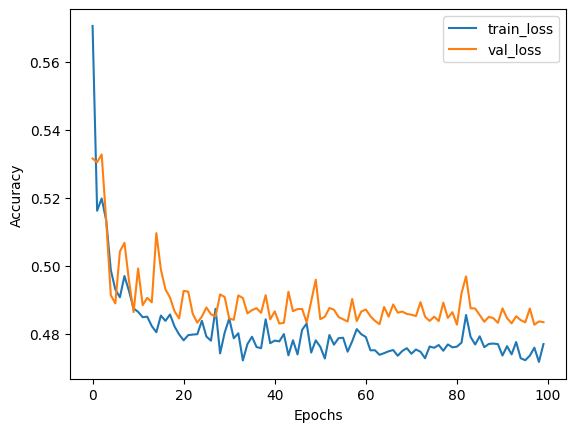

In [10]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
%tensorboard --logdir logs
